# Random Forest Classifier
Neste notebook usamos o classificador Random Forest para determinar de acordo com as características do anúncio do carro se a coluna 'price' (preço) está em uma das seguintes faixas de preço:

- very low price
- low price
- average low price
- average price
- average high price
- high price
- very high price

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from Utils import run_classifier_and_track, eval_classifier_metrics

RANDOM_FOREST_CLASSIFIER_EXPERIMENT = "RandomForestClassifier"

In [8]:
##Preparação do Dataframe

train = pd.read_csv('../datasets/classifier/train_classifier_vehicles.csv')
test = pd.read_csv('../datasets/classifier/test_classifier_vehicles.csv')
valid = pd.read_csv('../datasets/classifier/validation_classifier_vehicles.csv')

def set_categories(df, categories):
    df[categories] = df[categories].astype('category')

def set_codes(df, categories):    
    for category in categories:
        df[category] = df[category].cat.codes
    return df

categories = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'state','pricecategory']
categories2 = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'state']

set_categories(train, categories)
train['pricecode'] = train.pricecategory.cat.codes
set_codes(train, categories2)

set_categories(test, categories)
test['pricecode'] = test.pricecategory.cat.codes
set_codes(test, categories2)

set_categories(valid, categories)
valid['pricecode'] = valid.pricecategory.cat.codes
set_codes(valid, categories2)

,year,manufacturer,fuel,odometer,title_status,transmission,drive,type,state,pricecategory,pricecode
0,2013,7,2,87951,0,1,2,10,9,average low price,1
1,2014,7,2,118963,0,0,2,9,4,average high price,0
2,2006,8,2,110000,0,0,2,8,38,average price,2
3,2012,23,2,97211,0,0,0,0,1,average high price,0
4,2016,20,2,55493,0,0,0,0,30,high price,3
...,...,...,...,...,...,...,...,...,...,...,...
59341,2014,13,2,34500,0,0,2,2,48,high price,3
59342,2012,34,0,152270,0,0,3,7,2,high price,3
59343,2010,18,2,103378,0,0,2,8,1,average low price,1
59344,2015,20,2,67335,0,2,3,10,4,average high price,0


In [9]:
##Divisão de entre treino e teste
x_train = train.drop(['pricecategory'],axis = 1)
y_train = train['pricecode']

x_test = test.drop(['pricecategory'],axis = 1)
y_test = test['pricecode']

In [15]:
#Create a Random Forest Classifier and track
params = {'n_estimators': 100, 'max_depth': None, 'max_features': 'auto'}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], max_features=params['max_features'])
run_classifier_and_track(x_train, 
                         'train_classifier_vehicles.csv',
                         x_test, 
                         'test_classifier_vehicles.csv',
                         model, 
                         RANDOM_FOREST_CLASSIFIER_EXPERIMENT, 
                         'pricecode', 
                         'RandomForestClassifier',
                         params)

train_Accuracy: 0.9975

test_Accuracy: 0.6827



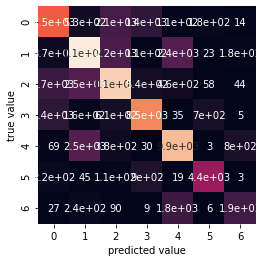

In [16]:
y_model = model.predict(x_test.drop(columns=['pricecode']))
mat = confusion_matrix(y_test, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

## Otimizando hiperparâmetros
Vamos usar o optuna para otimizar os parâmetros:
- n_estimators
- max_depth
- max_features

In [18]:
import optuna
import sklearn.model_selection

In [21]:
def objective(trial):
    x_df = valid.drop(columns=['pricecategory', 'pricecode'])
    target = valid['pricecode']
    
    classifier_name = trial.suggest_categorical('classifier', ['RandomForestClassifier'])
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, step=10)
    max_depth = trial.suggest_int('max_depth', 10, 110, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    classifier_obj.fit(x_df, target)
    predict = classifier_obj.predict(x_df)

    metrics = eval_classifier_metrics(target, predict, False)
    accuracy = metrics['test_accuracy']
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2020-11-17 20:51:49,089] A new study created in memory with name: no-name-b0b2c926-7c9f-45be-ae77-3aed70240555
[I 2020-11-17 20:52:00,405] Trial 0 finished with value: 0.9987025241802312 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 100, 'max_depth': 91, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9987025241802312.
[I 2020-11-17 20:52:57,318] Trial 1 finished with value: 0.9987193745155528 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 470, 'max_depth': 44, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9987193745155528.
[I 2020-11-17 20:54:58,885] Trial 2 finished with value: 0.9987193745155528 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 980, 'max_depth': 68, 'max_features': 'auto'}. Best is trial 1 with value: 0.9987193745155528.
[I 2020-11-17 20:55:56,596] Trial 3 finished with value: 0.9987193745155528 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 540, 

KeyboardInterrupt: 

(Decidimos parar antes por questão de tempo e não estar havendo mais otimizações nas execuções seguintes)

Os valores dos parâmetros foram:
- n_estimators = 470
- max_depth = 44
- max_features = 'sqrt'

In [22]:
params = {'n_estimators': 470, 'max_depth': 44, 'max_features': 'sqrt'}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], max_features=params['max_features'])
run_classifier_and_track(x_train, 
                         'train_classifier_vehicles.csv',
                         x_test, 
                         'test_classifier_vehicles.csv',
                         model, 
                         RANDOM_FOREST_CLASSIFIER_EXPERIMENT, 
                         'pricecode', 
                         'RandomForestClassifierWithTunning',
                         params)

train_Accuracy: 0.9975

test_Accuracy: 0.6846

